In [25]:
# Loading libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [2]:
# Import the dataset
kickstarter = pd.read_excel('Kickstarter.xlsx')

In [101]:
# For the purpose of this project, we only need to include projects with "successful" or "failure" state
df = kickstarter[kickstarter['state'].isin(['successful','failed'])]
df.head()

,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,...,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days
0,1601563193,Our future,100000000.0,1.00,failed,False,AU,AUD,2014-10-07 12:05:39,2014-10-07 12:05:39,...,1,2014,21,8,8,2014,12,6,60,60
1,880009511,Elite: Dangerous,1250000.0,1578316.08,successful,False,GB,GBP,2013-01-04 18:00:57,2013-01-04 18:00:57,...,31,2012,11,11,5,2012,18,5,60,60
4,557230947,"Bring Reading Rainbow Back for Every Child, Ev...",1000000.0,5408916.95,successful,False,US,USD,2014-07-02 14:00:00,2014-07-02 14:00:11,...,22,2014,22,5,28,2014,8,35,35,35
5,1966069095,ARKYD: A Space Telescope for Everyone,1000000.0,1505366.60,successful,False,US,USD,2013-06-30 21:00:00,2013-06-30 21:00:34,...,10,2012,17,5,29,2013,10,322,32,32
6,2083255961,A Billion Pixels...,100000000.0,56.00,failed,False,US,USD,2014-08-04 16:39:34,2014-08-04 16:39:34,...,1,2014,16,6,5,2014,16,34,60,60


# 1. Data Preprocessing

In [80]:
# Check the number of rows and columns 
df.shape

(13435, 45)

### 1.1 Detect Duplicated Records

In [ ]:
# Check if there is any duplicated records
df[df.duplicated()]

### 1.2 Detect Missing Values

In [81]:
# Check if there is any missing values
missing_values = np.where(pd.isnull(df))

In [ ]:
# Identify the columns that contain missing values
df.columns[list(set(np.where(pd.isnull(df))[1]))]

In [83]:
# Count the percentage of missing values
len(missing_values[0]) / df.shape[0]

0.09341272794938593

The predictors might be important for our future prediction.
And the number of records that contains missing values isn't significant in this dataset.
Hence we drop the missing values.

In [53]:
df = df.dropna()
df.shape

(12180, 45)

### 1.3 Drop out-of-scope predictors

According to the project instruction, we can only use the predictors "that are available at the moment when a new project is launched."
Therefore, we do not need any predictors regarding 'states' of the project.

In [102]:
df = df.drop(columns = ['state_changed_at','state_changed_at_weekday','state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr','state_changed_at_hr','launch_to_state_change_days'])

The information about pledged, staff_pick, backers_count, spotlight wont be available at the moment when the project is launched. Therefore, we remove them as well.

In [103]:
df = df.drop(columns = ['pledged','staff_pick','backers_count','spotlight'])

### 1.4 Identify unique identifiers

In [ ]:
# Number of unique values
df.nunique()

In [104]:
# Note that disable_communication only have one unique value
# So it won't be useful for our prediction
df = df.drop(columns = ['disable_communication'])

In [105]:
# we can drop [id, name, deadline, created_at, launched_at] as they are almost a unique identifier
df= df.drop(columns = ['id','name','deadline', 'created_at', 'launched_at'])

### 1.5 Detect collinearity between variables

C:\Users\shans\AppData\Local\Temp\ipykernel_7880\3011241796.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


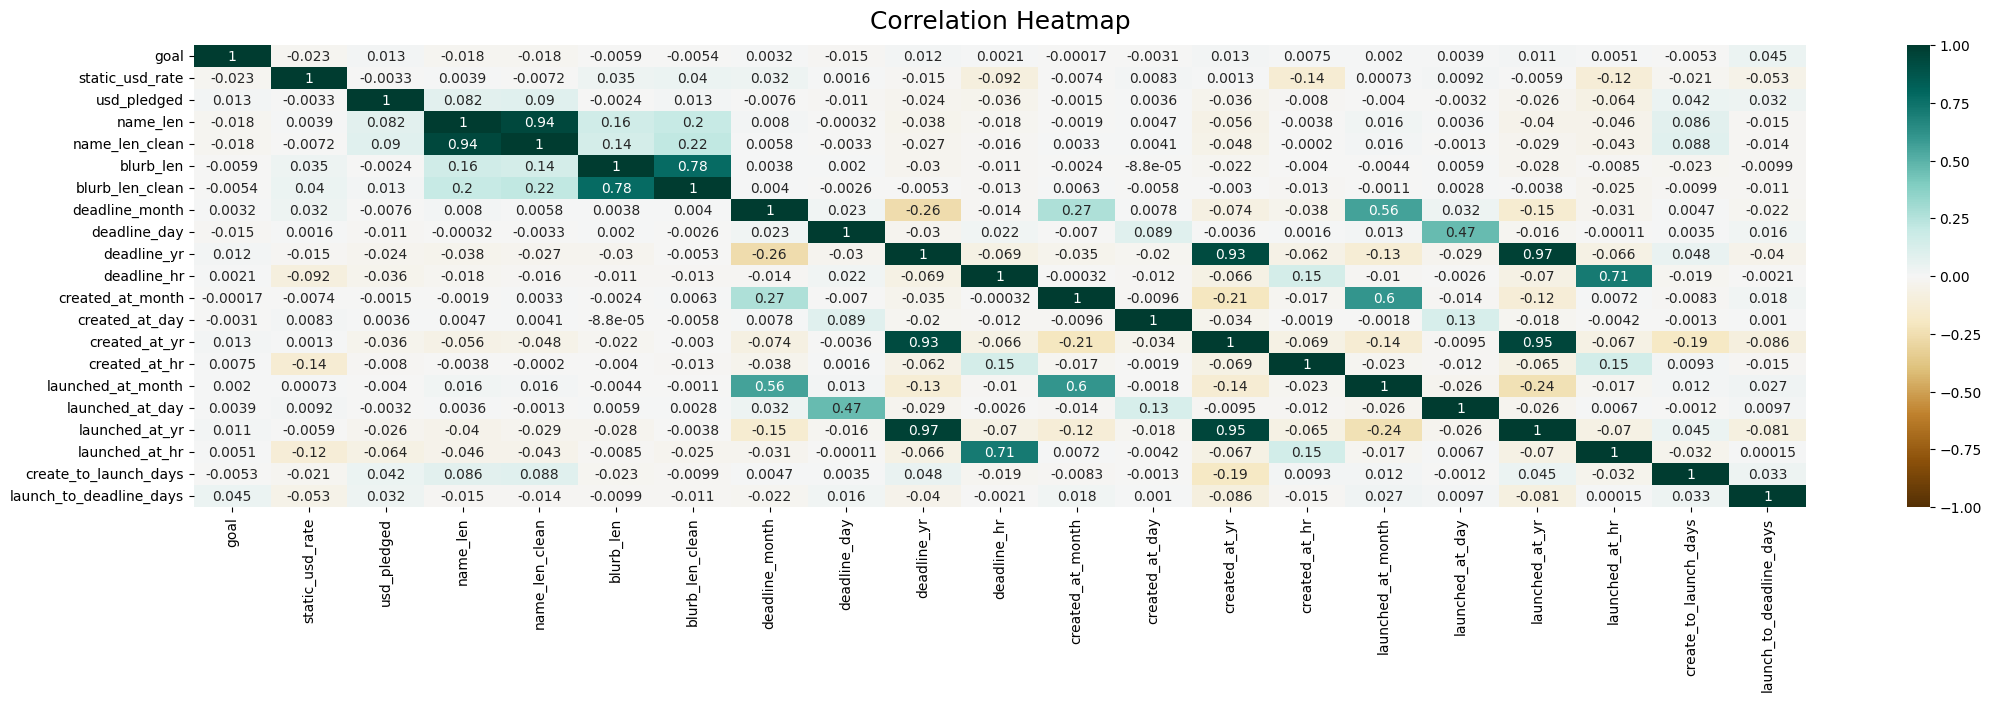

In [106]:
# check if there is any collinearity between variables
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

According to the correlation heatmap, following varaibles have high correlation:
- usd_pledged and pledged, 
- name_len and name_len_clean, 
- blurb_len and blurb_len_clean,
- deadline_yr and created_at_yr and launched_at_yr
For each pair, we only need to keep one of them.

In [107]:
df = df.drop(columns = ['usd_pledged','name_len_clean','blurb_len_clean','created_at_yr', 'launched_at_yr'])

### 1.6 Handle Categorical Variables

In [ ]:
# Check variable types
df.dtypes

In [ ]:
# For 'weekday' variables. convert them into numerical variable from 1-7
cols = ['deadline_weekday','created_at_weekday','launched_at_weekday']
df[cols] = df[cols].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

In [ ]:
# dummify the other categorical variables
df = pd.get_dummies(df, columns = ['country','currency','category'])
df.columns

# or just drop them
#df = df.drop(columns = ['country','currency','category'])

In [110]:
# Convert the target variable to binary
df['state'] = df['state'].replace(['successful','failed'],[1,0])
df['state']

0        0
1        1
4        1
5        1
6        0
        ..
15467    0
15469    0
15470    0
15472    1
15473    1
Name: state, Length: 13435, dtype: int64

### 1.7 Remove outliers

Build a random forest to detect anomalies

In [ ]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=100,contamination=0.1,random_state=3)

pred = iforest.fit_predict(df)
score = iforest.decision_function(df)

In [78]:
#df.columns[list(set(np.where(pd.isnull(df))[1]))]
df[df['goal'] == 100000000]

,goal,state,static_usd_rate,name_len,blurb_len,deadline_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,...,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries
6,100000000.0,0,1.0,3.0,17.0,1,4,4,8,4,...,0,0,0,0,0,0,0,0,1,0


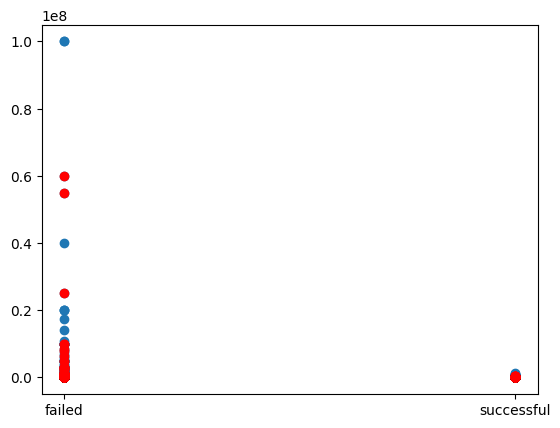

In [86]:
## Extracting anomalies
from numpy import where
anomaly_index = where(pred==-1)
anomaly_values = df.iloc[anomaly_index]
anomaly_index

from matplotlib import pyplot
pyplot.scatter(df['state'],df['goal'])
pyplot.scatter(anomaly_values['state'],anomaly_values['goal'],color='r')

In [ ]:
for idx in anomaly_index:
    print(df.iloc[idx,:])
    #df = df.drop(idx, errors='ignore')

In [28]:
df.shape

(11202, 70)

### Feature Selection

In [111]:
X = df.loc[:,df.columns != 'state']
y = df['state']

#### Using LASSO

In [112]:
## Standardize the predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std_lasso = scaler.fit_transform(X)

In [113]:
## Run LASSO
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.03)
model_lasso = lasso.fit(X_std_lasso,y)

model_lasso.coef_

test = pd.DataFrame(list(zip(X.columns,model_lasso.coef_)), columns = ['predictor','coefficient'])
test[abs(test['coefficient']) >= 0.01].sort_values(by = 'coefficient')

,predictor,coefficient
67,category_Web,-0.079501
62,category_Software,-0.052434
18,launch_to_deadline_days,-0.018776
9,deadline_yr,-0.012921
59,category_Plays,0.024269
2,name_len,0.031426


#### Using Random Forest

<AxesSubplot: >

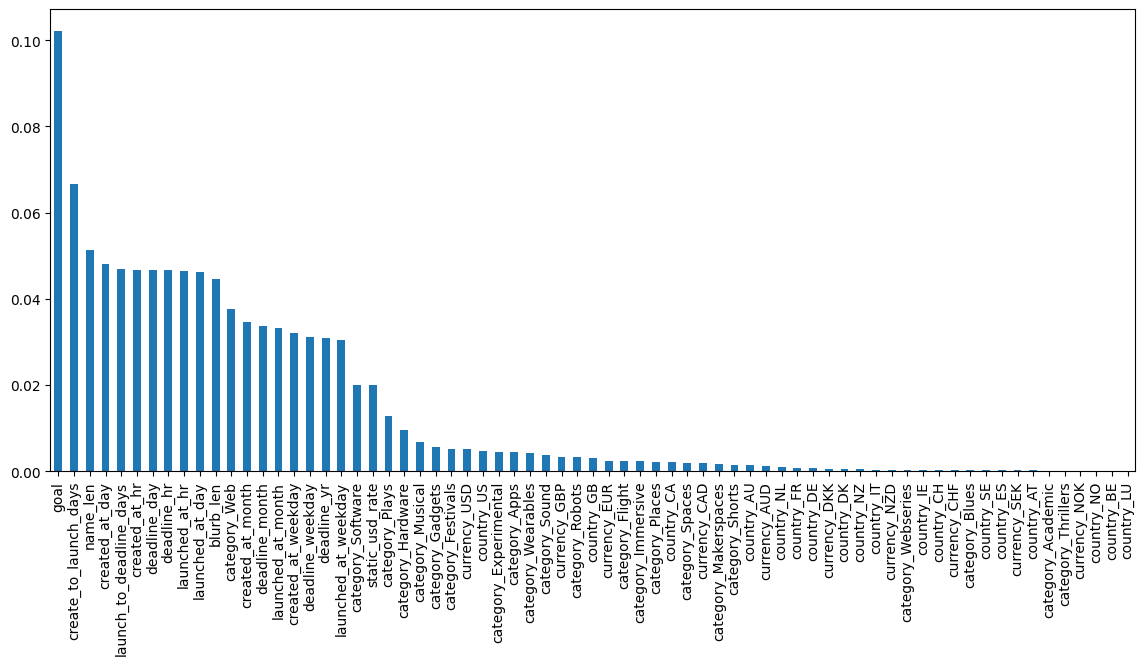

In [114]:
# Split the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=5)

# Build the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0)
model_rf = rf.fit(X_train, y_train)

# Print feature importance
pd.Series(model_rf.feature_importances_, index = X.columns).sort_values(ascending = False).plot(kind = 'bar',figsize = (14,6))

# Classification Model

In [115]:
# Using predictors found by Random Forest
X = df[['goal','create_to_launch_days','name_len','launch_to_deadline_days',
'launched_at_hr','launched_at_day','created_at_day','created_at_hr','deadline_day','blurb_len',
 'category_Web','created_at_month','deadline_month','created_at_weekday','launched_at_weekday','deadline_yr',
 'category_Software','static_usd_rate','category_Plays','category_Festivals','category_Hardware','category_Musical']]

# Predictors found by LASSO
# X = df[['category_Web','category_Software','category_Plays','name_len','launch_to_deadline_days','category_Festivals']] #,'deadline_yr','category_Musical']]

# combine the top selections?
# X = df[['goal','create_to_launch_days','name_len','launch_to_deadline_days',
# 'category_Web','category_Software','category_Plays','category_Festivals']] #,'deadline_yr','category_Musical']]


y = df["state"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.30, random_state = 5)

### Logistic Regression

In [116]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 500)
model_logit = lr.fit(X_train, y_train)

y_test_pred = model_logit.predict(X_test)

from sklearn import metrics
print("accuracy:", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:", metrics.precision_score(y_test, y_test_pred))
print("Recall:", metrics.recall_score(y_test, y_test_pred))
print("F1 score:", metrics.f1_score(y_test, y_test_pred))

accuracy: 0.7013148102207889
Precision: 0.6041896361631753
Recall: 0.39339554917444364
F1 score: 0.47652173913043483


### Random Forest

In [117]:
# Build the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0)
model_rf = rf.fit(X_train, y_train)

y_test_pred = model_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
f1_score = metrics.f1_score(y_test, y_test_pred)

model_rf_metrics = [accuracy, precision, recall, f1_score]
model_rf_metrics

[0.7395187298437113, 0.6727089627391742, 0.47954055994257, 0.5599329421626152]

### K-Nearest Neighbors

In [ ]:
from sklearn.metrics import accuracy_score
for i in range (1,21):
    knn = KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(X_train,y_train)
    y_test_pred = model.predict(X_test)
    print("k = ", i, "accuracy =", accuracy_score(y_test, y_test_pred))

In [118]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=18) #,  weights = 'distance')

from sklearn import metrics
model_knn = knn.fit(X_train, y_train)

y_test_pred = model_knn.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
f1_score = metrics.f1_score(y_test, y_test_pred)

model_knn_metrics = [accuracy, precision, recall, f1_score]
model_knn_metrics

[0.6861820888117093,
 0.5824742268041238,
 0.32447954055994255,
 0.41678192715537116]

### Artificial Neural Network

In [ ]:
# Find the optimal size of hidden layer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
for i in range(1,21): 
    model = MLPClassifier(hidden_layer_sizes=(i), max_iter = 1000, random_state=0)
    scores = cross_val_score(model, X=X_std, y=y, cv=10)
    print(i, ":", np.average(scores))

In [119]:
from sklearn.neural_network import MLPClassifier
model_ann = MLPClassifier(hidden_layer_sizes=(14), random_state=0)
model_mlp = model_ann.fit(X_train,y_train)

y_test_pred = model_mlp.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
f1_score = metrics.f1_score(y_test, y_test_pred)

model_mlp_metrics = [accuracy, precision, recall, f1_score]
model_mlp_metrics

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.7129744480277846, 0.618, 0.44364680545585067, 0.5165064772252403]

### Support Vector Machine

In [ ]:
# Find the optimal gamma
from sklearn.svm import SVC
for i in range(1,11):
    svm_rbf = SVC(kernel = "rbf", random_state=0, C =0.5, gamma = i)
    model_rbf = svm_rbf.fit(X_train,y_train)
    scores = cross_val_score(model_rbf,X=X_test, y=y_test, cv=10)
    print("gamma = ",i,", score = ", sum(scores)/len(scores))

In [135]:
# Build the SVM model using a linear model
from sklearn.svm import SVC
svm = SVC(kernel="linear", random_state=0, C=0.5, gamma = 3)
model_svm = svm.fit(X_train, y_train)

y_test_pred = model_svm.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
f1_score = metrics.f1_score(y_test, y_test_pred)

model_svm_metrics = [accuracy, precision, recall, f1_score]
model_svm_metrics

[0.6802282312081369,
 0.5966542750929368,
 0.23043790380473797,
 0.3324702226825479]

### Lazy Classifier

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

# Evaluation on Grading Dataset

In [120]:
# Loading libraries
import pandas as pd
import numpy as np

# Import the dataset
grading = pd.read_excel('Kickstarter-Grading-Sample.xlsx')

# For the purpose of this project, we only need to include projects with "successful" or "failure" state
df_test = grading[grading['state'].isin(['successful','failed'])]

# Data Preprocessing
df_test = df_test.dropna()

### Drop out-of-scope predictors
df_test = df_test.drop(columns = ['state_changed_at','state_changed_at_weekday','state_changed_at_month', 
'state_changed_at_day', 'state_changed_at_yr','state_changed_at_hr','launch_to_state_change_days',
'pledged','staff_pick','backers_count','spotlight','disable_communication',
'id','name','deadline', 'created_at', 'launched_at','usd_pledged','name_len_clean','created_at_yr', 'launched_at_yr'])

### Handle Categorical Variables
cols = ['deadline_weekday','created_at_weekday','launched_at_weekday']
df_test[cols] = df_test[cols].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

# dummify the other categorical variables
df_test = pd.get_dummies(df_test, columns = ['country','currency','category'])
# or just drop them
#df = df.drop(columns = ['country','currency','category'])

df_test['state'] = df_test['state'].replace(['successful','failed'],[1,0])


# Testing
#X_grade = df_test[['goal','create_to_launch_days','name_len','launch_to_deadline_days',
#'category_Web','category_Software','category_Plays','category_Festivals']]

X_grade = df_test[['goal','create_to_launch_days','name_len','launch_to_deadline_days',
'launched_at_hr','launched_at_day','created_at_day','created_at_hr','deadline_day','blurb_len',
 'category_Web','created_at_month','deadline_month','created_at_weekday','launched_at_weekday','deadline_yr',
 'category_Software','static_usd_rate','category_Plays','category_Festivals','category_Hardware','category_Musical']]

# X_grade = df_test[['category_Web','category_Software','category_Plays','name_len','launch_to_deadline_days','category_Festivals']] #,'deadline_yr','category_Musical']]

y_grade = df_test["state"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_grade = scaler.fit_transform(X_grade)




In [128]:
def model_metrics(model,X,y):
    y_pred = model.predict(X)

    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1_score = metrics.f1_score(y, y_pred)

    model_metrics = [accuracy, precision, recall, f1_score]
    return model_metrics

In [138]:
test_performance = {
    'KNN': model_metrics(model_knn,X_grade,y_grade),
    'ANN': model_metrics(model_ann,X_grade,y_grade),
    'Logitstic': model_metrics(model_logit,X_grade,y_grade),
    'RandomForest': model_metrics(model_rf,X_grade,y_grade),
    'SVM': model_metrics(model_svm,X_grade,y_grade)
}

pd.DataFrame.from_dict(test_performance, orient='index',columns = ['accuracy','percision','recall','f1_score'])

,accuracy,percision,recall,f1_score
KNN,0.721384,0.648415,0.412088,0.503919
ANN,0.701258,0.551674,0.694139,0.614761
Logitstic,0.726415,0.591736,0.655678,0.622068
RandomForest,0.671698,0.515038,0.752747,0.611607
SVM,0.723899,0.670927,0.384615,0.488941
